# Algoritmos Genéticos para el problema de Asignación Cuadrática

## Parte 1. Implementación del problema

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class QAProblem:
    def __init__(self, n, distances, flows):
        self.n = n
        self.distances = distances
        self.flows = flows
        self.best_fit_record = []
        self.best_fit = np.Inf
        self.best_sol = []

    # Llamada a la función objetivo (fitness)
    def __call__(self, solution):
        # Cada solución es un arreglo de números enteros no negativos consecutivos en el rango [0, n-1]
        # El valor solution[i] es la ubicación en la que será construida la instalación [i]
        perm_dist = self.distances[solution,:][:,solution]
        fit = int(np.multiply(self.flows, perm_dist).sum())

        # Recording the best fit over each function call
        if fit < self.best_fit:
            self.best_fit = fit
            self.best_sol = solution.tolist()
        
        self.best_fit_record.append(self.best_fit)

        return fit

    # Lectura del fichero de datos del problema
    def build_from_file(path):
        with open(path, "r") as f:
            n = int(f.readline().strip())
            distances, flows = np.zeros((n, n), dtype=int), np.zeros((n, n), dtype=int)
            _ = f.readline()
            for i in range(n):
                flows[i,:] = (list(map(int, f.readline().split())))
            for j in range(n):
                distances[j,:] = (list(map(int, f.readline().split())))
        return QAProblem(n, distances, flows)
    
    def reset_stats(self):
        self.best_fit_record = []
        self.best_fit = np.Inf
        self.best_sol = []

### 1.1 Instanciando al problema y visualizando las matrices de flujo entre *facilities* y distancia entre *locations*

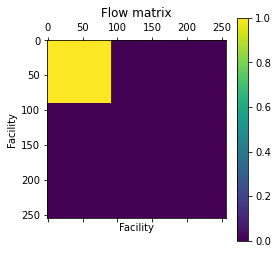

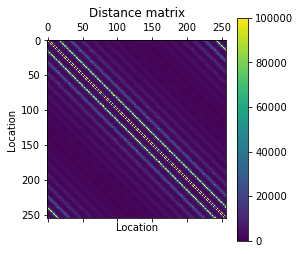

In [2]:
problem = QAProblem.build_from_file(path="tai256c.dat")

plt.matshow(problem.flows)
plt.colorbar()
plt.xlabel("Facility")
plt.ylabel("Facility")
plt.title("Flow matrix")
plt.show()

plt.matshow(problem.distances)
plt.xlabel("Location")
plt.ylabel("Location")
plt.colorbar()
plt.title("Distance matrix")
plt.show()



### 1.2 Generando soluciones de ejemplo y evaluándolas en el problema

In [3]:
np.random.seed(123)
solutions = np.array([np.random.permutation(problem.n) for i in range(2)], dtype=int)
fitnessess = np.array([problem(solution) for solution in solutions], dtype=int)
for s, f in zip(solutions, fitnessess):
    print(f"{s} -> {f}\n")

[ 30  82 107 207 192 173 235 234  24  42 178 141  90  29 193  20 177 210
  89  19 236 137 200  31 161 223  91 251 130 231  61  72 203 239 120 100
  85  81 160 197 114 243 142  53  33  37  80 216   5   4 147  52  71 201
  21 232 196 219 237 143 150 128  23 182 213 188 233  10  26  11 122  62
  54 183  79  35 244 132 136 172 222  50 198 248 157 199 167 206  41 171
 152 184 119 215  95 245 191 240 211 205 125 156 249   8  77 194 112 169
 151 228  36 218  63 108  28  13 186  88 127   7 170  44 229 202 144  65
  60 227  93 226 179   0  45  40  59 190  46 166 185 104 133  16 217 148
 116 212  74 110 145  38  27 140 121 181  87   9   6 159 163 165 250 187
 149 139  67   3  86 175  48 117  51   1  18  12 242  56  25 101  43 129
 103  14 134 154 115 255  70 209 158 204  15 146  22 138  58 162  75  64
  69 246 131 168  76  34 155  94 118  97 102 180  92 124  99 105 135 176
 189 238 221 252  39  84   2 195  55  49  68 208 241 164  78 247 153 111
 224 174  32  73  47 253 113  96 225 214  57 123 10

## Parte 2. Operadores y algoritmo genético tradicional

## 2.1 Operadores

En esta sección implementaremos los operadores que serán comunes para los tres algoritmos. La idea es incluir estas funciones apropiadamente en las clases que se implementarán posteriormente.

In [4]:
import numpy as np
from difflib import SequenceMatcher

def selection_tournament(pop_fitness, prop_tourn:float=0.2):
    """
    selection_tournament implementa el operador de selección 
    por torneo para un algoritmo genético que usa codificación de 
    soluciones basada en permutaciones.

    :param pop_fitness: una lista o arreglo con los fitness de los individuos de la población
    :param prop_tourn: proporción de individuos que conforman la muestra del torneo
    :return: los índices de los dos individuos seleccionados
    """ 

    # Validación sobre el valor del porcentaje de soluciones 
    # que participan en el torneo. Se garantiza que la tasa 
    # se encuentre entre 0.1 y 1.0.
    prop_tourn = max(0.1, prop_tourn)
    prop_tourn = min(1., prop_tourn)
    
    # Tamaño de la población (cantidad de soluciones)
    p_size = len(pop_fitness)

    # Se calcula el tamaño del torneo (cantidad de soluciones participantes)
    # Se redondea por exceso con "ceil". En particular, tourn_size <= p_size.
    tourn_size = int(np.ceil(prop_tourn * p_size))

    # Se elige una submuestra aleatoria de tamaño tourn_size de la población
    # Esta submuestra está compuesta por los índices de los individuos
    sub_sample_1 = np.random.permutation(p_size)[range(tourn_size)]
    
    # Identificamos al mejor de esa submuestra, esto es, el que tiene el menor 
    # fitness (valor de la función objetivo)
    best1_indx = np.argmin(pop_fitness[sub_sample_1])
    
    # Nos quedamos con el índice del individuo en la población original
    orig_best1_indx = sub_sample_1[best1_indx]

    # Ahora nos planteamos encontrar, por el mismo procedimiento anterior,
    # el otro "mejor" individuo, garantizando que sea diferente al que
    # ya elegimos anteriormente (de ahí el uso del while).
    orig_best2_indx = orig_best1_indx
    while(orig_best1_indx ==  orig_best2_indx):
        sub_sample_2 = np.random.permutation(p_size)[range(tourn_size)]
        best2_indx = np.argmin(pop_fitness[sub_sample_2])
        orig_best2_indx = sub_sample_2[best2_indx]

    # Al finalizar, devolvemos los índices (en la población orignal) 
    # de los individuos seleccionados.
    return orig_best1_indx, orig_best2_indx


def crossover_ordered(parent1, parent2, low_rate=0.3, upp_rate=0.7):
    l = len(parent1)

    par_size = int(np.ceil( l * np.random.uniform(low=low_rate, high=upp_rate, size=1))[0])
    
    start_point = np.random.randint(l)
    cop_points = (start_point + np.array(range(par_size))) % l
    end_point = (start_point + par_size) % l
    rep_points_all = (end_point + np.array(range(l))) % l
    rep_points = rep_points_all[0:(l - par_size)]

    off1 = np.zeros(l, dtype=int)
    off2 = np.zeros(l, dtype=int)

    off1[cop_points] = parent1[cop_points]
    off2[cop_points] = parent2[cop_points]

    parent2_cont = np.setdiff1d(parent2[rep_points_all], off1[cop_points], assume_unique=True)
    parent1_cont = np.setdiff1d(parent1[rep_points_all], off2[cop_points], assume_unique=True)

    off1[rep_points] = parent2_cont[0:(l - par_size)]
    off2[rep_points] = parent1_cont[0:(l - par_size)]

    return off1, off2


def mutation_swap(individual, mutation_rate:float, inplace=True):
    """Mutation operator by swapping random positions

    Args:
        individual (list, ArrayLike): the individual to mutate
        mutation_rate (float): mutation rate (proportion of position to be exchange)
        inplace (bool, optional): whether the changes is performed in the passed invidual (True) or 
        in one copy of it (False). Defaults to True.

    Returns:
        list, ArrayLike: mutated individual
    """

    # Se decide si se hará sobre el individuo, 
    # o si se devuelve una copia del mismo
    if inplace:
        mutated_invidual = individual
    else:
        mutated_invidual = individual.copy()

    # Determinamos el tamaño del individuo (dimensión de la solución)
    dimension = len(individual)

    # Tamaño de la mutación (cantidad de posiciones que serán intercambiadas)
    mutation_size = int(np.ceil(np.random.uniform(0, mutation_rate) * dimension))

    # Seleccionamos las posiciones (índices) que serán intercambiadas
    random_positions = np.random.permutation(dimension)[0:mutation_size]

    # Desordenamos las posiciones seleccionadas
    swapped_positions = np.random.permutation(random_positions)

    # Intercambiamos las posiciones
    mutated_invidual[random_positions] = mutated_invidual[swapped_positions]
    
    # Devolvemos el individuo mutado
    return mutated_invidual


def replace_fitness_based(pop_fitness, sel_size:int):
    return np.argsort(pop_fitness)[range(sel_size)]


def replacement_age_based(pop_fitness, sel_size:int):
    return range(sel_size, len(pop_fitness))


def identify_most_influencial_pair(problem:QAProblem, individual):
    perm_dist = problem.distances[individual,:][:,individual]
    cost_matrix = np.multiply(problem.flows, perm_dist)
    coord = np.unravel_index(cost_matrix.argmax(), cost_matrix.shape)
    max_val = cost_matrix.max()
    return coord, max_val

def population_diversity(population) -> float:
    pop_size, _ = np.shape(population)
    result_matrix = np.zeros(shape=(pop_size, pop_size))

    for i in range(pop_size):
        ind = population[i,:].tolist()
        matches = np.apply_along_axis(lambda x: SequenceMatcher(None, a=ind, b=x.tolist()).ratio(), 1, population)
        result_matrix[i, :] = matches

    return np.tril(result_matrix, k=-1).sum()/((pop_size**2 - pop_size)/2)

def population_diversity_sd(population) -> float:

    mean_individual = np.mean(population, axis=0)

    diff_matrix = np.abs(population - mean_individual)

    return round(np.mean(diff_matrix)/255., 3)



### 2.1.1 Probando los operadores

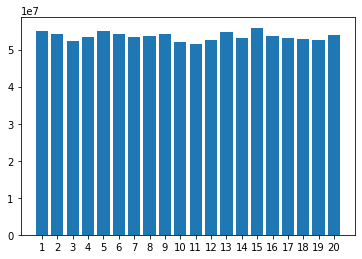

Sol1 = 16 Sol2=10
Sol1 = 10 Sol2=17
Sol1 = 17 Sol2=2
Sol1 = 11 Sol2=17


In [5]:
np.random.seed(123)
pop_size = 20
solutions = np.array([np.random.permutation(problem.n) for i in range(pop_size)], dtype=int)
fitnessess = np.array([problem(solution) for solution in solutions], dtype=int)

plt.bar(x=np.arange(1,pop_size+1), height=fitnessess)
plt.xticks(np.arange(1,pop_size+1))
plt.show()

# Probando el operador de selección

sol1, sol2 = selection_tournament(fitnessess, prop_tourn=0.3)
print(f"Sol1 = {sol1} Sol2={sol2}")
sol1, sol2 = selection_tournament(fitnessess, prop_tourn=0.3)
print(f"Sol1 = {sol1} Sol2={sol2}")

sol1, sol2 = selection_tournament(fitnessess, prop_tourn=0.3)
print(f"Sol1 = {sol1} Sol2={sol2}")
sol1, sol2 = selection_tournament(fitnessess, prop_tourn=0.3)
print(f"Sol1 = {sol1} Sol2={sol2}")


In [6]:
from tqdm import tqdm


class TraditionalGA:
    def __init__(self, qa_problem:QAProblem, pop_size:int=50, crossover_rate:float=0.8, mutation_rate:float=0.05, replace_fn=replace_fitness_based) -> None:
        self.qa_problem = qa_problem
        self.pop_size = pop_size
        self.cross_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = np.empty((self.pop_size, self.qa_problem.n),  dtype=int)
        self.fitness = np.zeros(self.pop_size, dtype=int)
        self.replace = replace_fn
        self.sorted_fit_indxs = []

    def initialize(self):
        for i in range(self.pop_size):
            x = np.random.permutation(self.qa_problem.n)
            f = self.qa_problem(x)
            self.population[i,:] = x
            self.fitness[i] = f
        
        self.sorted_fit_indxs = np.argsort(self.fitness)

    def select(self):
        # Parent selection for crossover
        par1_idx, par2_idx = selection_tournament(self.fitness, prop_tourn=0.3)
        par1 = self.population[par1_idx]
        par2 = self.population[par2_idx]
        return par1, par2
    
    def crossover(self, par1, par2):
        # Crossover
        if(np.random.random() < self.cross_rate):
            off1, off2 = crossover_ordered(par1, par2)
        else:
            off1, off2 = par1.copy(), par2.copy()
        return off1, off2


    def mutate(self, off1, off2):
        # Mutation
        mutation_swap(off1, self.mutation_rate)
        mutation_swap(off2, self.mutation_rate)
        return off1, off2

    def evaluate(self, individual):
        return self.qa_problem(individual)

    def evolve(self):
        par1, par2 = self.select()
        off1, off2 = self.crossover(par1, par2)
        if np.random.random() < self.mutation_rate:
            off1, off2 = self.mutate(off1, off2)

        # Offspring fitness evaluation
        fit1 = self.evaluate(off1)
        fit2 = self.evaluate(off2)

        return off1, fit1, off2, fit2

    def evolve_population(self):
        offspring = []
        off_fitness = []
        for i in range(self.pop_size//2):
            off1, fit1, off2, fit2 = self.evolve()
            # Adding the new individuals to the ofsspring pool
            offspring.append(off1)
            offspring.append(off2)
            off_fitness.append(fit1)
            off_fitness.append(fit2)

        return offspring, off_fitness
    
    def __call__(self, max_gens):
        
        self.initialize() # Esto cuenta como una iteración

        # best_age = 0

        pbar = tqdm(range(1, max_gens))
        
        for i in pbar:
            
            offspring, off_fitness = self.evolve_population()

            # Create an extender pool of individuals (population + offspring)
            all_fits = np.append(self.fitness, off_fitness)
            all_pop = np.append(self.population, offspring, axis=0)
            
            # Replacement: select the top p_size fittest individuals            
            rep_indxs = self.replace(all_fits, self.pop_size)
            
            self.population = all_pop[rep_indxs]
            self.fitness = all_fits[rep_indxs]

            self.sorted_fit_indxs = np.argsort(self.fitness)

            nota = round(max(5 - 100 * (problem.best_fit - 44759294)/44759294, 0),1)

            pop_div = population_diversity_sd(self.population)

            pbar.set_description(f"Best fitness: {self.qa_problem.best_fit} Pop.Div.: {pop_div} Nota: {nota}")




Best fitness: 47044834 Pop.Div.: 0.117 Nota: 0: 100%|██████████| 999/999 [00:35<00:00, 28.30it/s]

[112, 53, 134, 164, 228, 4, 108, 225, 52, 65, 31, 42, 149, 130, 154, 199, 10, 141, 143, 233, 7, 187, 211, 210, 158, 152, 236, 120, 75, 91, 83, 231, 254, 160, 102, 169, 68, 235, 11, 207, 44, 172, 35, 179, 245, 243, 161, 70, 56, 122, 181, 89, 29, 205, 155, 111, 183, 132, 88, 209, 78, 190, 106, 101, 213, 6, 176, 46, 80, 202, 18, 1, 24, 167, 57, 147, 201, 223, 21, 137, 50, 221, 255, 93, 32, 114, 39, 125, 248, 124, 62, 98, 191, 86, 49, 246, 14, 27, 66, 20, 219, 113, 64, 208, 5, 84, 174, 129, 69, 168, 8, 17, 196, 227, 51, 95, 63, 252, 105, 41, 180, 166, 3, 200, 251, 171, 117, 241, 222, 242, 19, 97, 239, 185, 188, 59, 13, 220, 36, 195, 133, 189, 74, 212, 100, 136, 186, 250, 142, 22, 150, 77, 67, 203, 99, 232, 253, 40, 230, 197, 238, 61, 138, 157, 128, 165, 55, 25, 12, 240, 9, 177, 204, 127, 82, 151, 192, 72, 247, 162, 244, 173, 123, 148, 159, 92, 126, 170, 76, 206, 45, 2, 15, 109, 90, 237, 140, 215, 47, 58, 30, 34, 145, 96, 107, 33, 178, 73, 16, 216, 103, 104, 156, 153, 226, 0, 139, 214, 229,

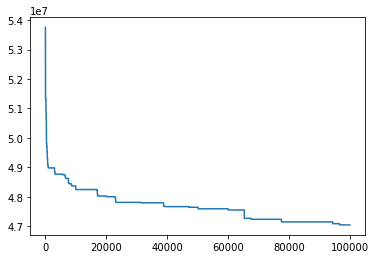

In [8]:
np.random.seed(1234)

problem = QAProblem.build_from_file(path="tai256c.dat")

ga_alg = TraditionalGA(qa_problem=problem, pop_size=100, crossover_rate=0.9, mutation_rate=0.015)

ga_alg(max_gens=1000)

print(problem.best_sol)

plt.plot(problem.best_fit_record)

In [ ]:
print(problem.best_sol)

[243, 110, 162, 119, 39, 14, 57, 139, 64, 224, 116, 96, 184, 56, 167, 237, 180, 250, 59, 102, 60, 226, 182, 104, 87, 7, 66, 212, 42, 70, 125, 153, 230, 92, 220, 52, 37, 9, 130, 174, 19, 177, 188, 234, 215, 122, 165, 27, 34, 213, 1, 194, 134, 245, 208, 201, 195, 253, 131, 159, 5, 12, 113, 107, 85, 190, 95, 232, 136, 49, 148, 31, 98, 2, 255, 222, 143, 207, 93, 171, 90, 24, 67, 219, 100, 186, 62, 157, 160, 22, 32, 45, 40, 248, 249, 44, 172, 103, 105, 74, 192, 97, 168, 209, 71, 33, 120, 48, 28, 146, 236, 106, 145, 132, 246, 223, 11, 54, 211, 118, 198, 30, 138, 225, 83, 47, 8, 227, 166, 58, 38, 101, 16, 199, 88, 124, 121, 144, 187, 193, 214, 21, 197, 94, 35, 81, 152, 127, 63, 196, 218, 189, 111, 89, 20, 241, 117, 79, 191, 17, 108, 170, 216, 123, 26, 78, 150, 202, 6, 179, 99, 73, 10, 61, 206, 69, 163, 29, 210, 161, 239, 158, 244, 137, 128, 41, 185, 240, 231, 205, 155, 156, 142, 176, 254, 53, 72, 221, 0, 114, 140, 23, 228, 75, 68, 13, 233, 109, 50, 173, 252, 200, 203, 91, 129, 133, 115, 235, 

In [ ]:
4/256

## Part 3. Algoritmos Genéticos con Búsqueda Local

## 3.1 Algoritmo 2-opt

In [22]:
import numpy as np

def swap_and_reverse(solution, init_pos:int, end_pos:int) -> list:
    changed_solution = solution.copy()
    changed_solution[init_pos:(end_pos+1)] = list(reversed(changed_solution[init_pos:(end_pos+1)]))
    return changed_solution


def two_opt(problem:QAProblem, solution, solution_fitness, swap_size):

    best_fitness = solution_fitness
    best_solution = solution.copy()

    swap_init = np.random.randint(problem.n - swap_size)

    swap_end = swap_init + swap_size

    for swap_first in range(swap_init, swap_end - 1):
        for swap_last in range(swap_first + 1, swap_end):

            new_solution = swap_and_reverse(best_solution, init_pos=swap_first, end_pos=swap_last)

            new_fitness = problem(new_solution)

            if new_fitness < best_fitness:
                best_fitness = new_fitness
                best_solution = new_solution.copy()
                
    return best_solution, best_fitness



## 3.2 Algoritmo Genético con Búsqueda Local Variante **Baldwiniana**

In [23]:
class BaldwinianGA(TraditionalGA):
    
    def __init__(self, qa_problem: QAProblem, pop_size: int = 50, crossover_rate: float = 0.8, mutation_rate: float = 0.05, replace_fn=replace_fitness_based, swap_size=10) -> None:
        super().__init__(qa_problem, pop_size, crossover_rate, mutation_rate, replace_fn)
        self.swap_size = swap_size

    def evaluate(self, individual):
        best_sol = individual.copy()
        best_fit = super().evaluate(individual)

        _, newfit = two_opt(problem=self.qa_problem, solution=best_sol, solution_fitness=best_fit, swap_size=self.swap_size)

        return newfit
    

np.random.seed(1234)

problem = QAProblem.build_from_file("tai256c.dat")

gaBald = BaldwinianGA(qa_problem=problem, pop_size=300, crossover_rate=0.9, mutation_rate=0.015, swap_size=5)

gaBald(1000)

print(problem.best_fit)

  0%|          | 0/999 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 3.3 Algoritmo Genético con Búsqueda Local Variante **Lamarckiana**

In [24]:
class LamarckianGA(TraditionalGA):
    
    def __init__(self, qa_problem: QAProblem, pop_size: int = 50, crossover_rate: float = 0.7, mutation_rate: float = 0.01, replace_fn=replace_fitness_based, swap_size=10) -> None:
        super().__init__(qa_problem, pop_size, crossover_rate, mutation_rate, replace_fn)
        self.swap_size = swap_size

    def evaluate(self, individual):
        best_sol = individual[:]
        best_fit = super().evaluate(individual)

        new_ind, new_fit = two_opt(problem=self.qa_problem, solution=best_sol, solution_fitness=best_fit, swap_size=self.swap_size)

        if new_fit < best_fit:
            individual[:] = new_ind.copy()

        return new_fit
    
np.random.seed(1234)

problem = QAProblem.build_from_file("tai256c.dat")

gaLam = LamarckianGA(qa_problem=problem, pop_size=300, crossover_rate=0.9, mutation_rate=0.015, swap_size=5)

gaLam(1000)

print(problem.best_fit)

  0%|          | 0/999 [00:00<?, ?it/s]

45659018
